In [32]:
import pandas as pd
import numpy as np
import ast
import mne
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

**Load Data**

In [23]:
data_path = '../Data/Processed/sub01_binned_raw.csv'
eeg_data_raw = pd.read_csv(data_path)

eeg_task_path = '../Data/Processed/sub01_binned_task_raw.csv'
eeg_task_raw = pd.read_csv(eeg_task_path)

data_path = '../Data/Processed/sub01_binned.csv'
eeg_data = pd.read_csv(data_path)

eeg_task_path = '../Data/Processed/sub01_binned_task.csv'
eeg_task = pd.read_csv(eeg_task_path)

**Load Features**

In [24]:
features_path = '../Data/Features/sub01_features_processed.csv'
features = pd.read_csv(features_path)

# Random Forest

**Features**

In [25]:
def rf_features(features):
    X = features.drop(columns=['label_type'])
    y = features['label_type']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy: .2f}')

    return rf

In [26]:
rf_flattened_features = rf_features(features)

Accuracy:  0.48


In [28]:
def plot_feature_importance(model, feature_names, top_n=20):
    """
    Plots the feature importance for the Random Forest model.
    
    Parameters:
        model (RandomForestClassifier): The trained Random Forest model.
        feature_names (list): List of feature names.
        top_n (int): Number of top features to display.
    """
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot the top N features
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n))
    plt.title('Top Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

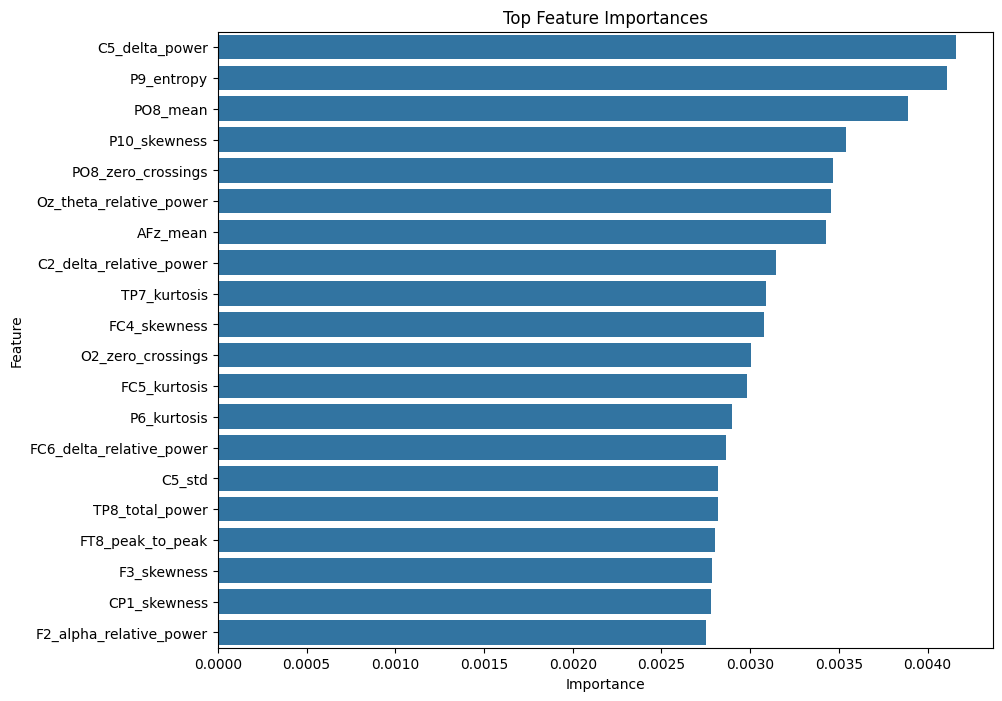

In [29]:
feature_names = features.drop(columns=['label_type']).columns
plot_feature_importance(rf_flattened_features, feature_names, top_n=20)

In [ ]:
def perform_rfe(X, y, n_features_to_select=10):
    model = RandomForestClassifier(random_state=42)
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_]

    X_selected = features[selected_features]

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy: .2f}')

**Flattened Dataset**

In [10]:
def flatten_eeg_data(eeg_data, max_length=2047):
    """
    Flattens the EEG data where each cell contains a list of floats.
    
    Parameters:
        eeg_data (pd.DataFrame): DataFrame with trials as rows and electrodes as columns.
        max_length (int): The fixed length to truncate or pad each list to.
        
    Returns:
        flattened_data (np.ndarray): 2D array with each row as a flattened trial.
        labels (np.ndarray): 1D array of labels corresponding to each trial.
    """
    # Step 1: Drop non-electrode columns like 'label' and 'label_type'
    eeg_data_filtered = eeg_data.drop(columns=['label', 'label_type'])

    # Step 2: Initialize lists to store flattened data and labels
    flattened_data = []
    labels = eeg_data['label_type'].values

    # Step 3: Iterate over each trial
    for trial in tqdm(range(eeg_data.shape[0]), desc='Flattening Data'):
        trial_data = []
        for col in eeg_data_filtered.columns:
            # Convert string to list of floats using ast.literal_eval
            channel_data = ast.literal_eval(eeg_data_filtered[col].iloc[trial])
            
            # Truncate or pad to max_length to ensure consistency
            if len(channel_data) > max_length:
                channel_data = channel_data[:max_length]
            else:
                channel_data = channel_data + [0] * (max_length - len(channel_data))
            
            # Append the flattened channel data
            trial_data.extend(channel_data)
        
        flattened_data.append(trial_data)
    
    # Convert flattened data to a NumPy array
    flattened_data = np.array(flattened_data)
    return flattened_data, labels

In [20]:
flattened_data, labels = flatten_eeg_data(eeg_data, max_length=2047)
print("Shape of flattened data:", flattened_data.shape)
print("Shape of labels:", labels.shape)

Flattening Data: 100%|██████████| 319/319 [02:36<00:00,  2.03it/s]


Shape of flattened data: (319, 131008)
Shape of labels: (319,)


In [12]:
def rf_flattened(eeg_data, labels, n_estimators=100):
    X_train, X_test, y_train, y_test = train_test_split(eeg_data, labels, test_size=0.2, random_state=42)

    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy: .2f}')

In [21]:
rf_flattened(flattened_data, labels, n_estimators=200)

Accuracy:  0.56


**Each Electrode**

In [39]:
def rf_each_electrode(eeg_data, n_estimators=100):
    electrode_data = eeg_data.drop(columns=['label', 'label_type'])
    y = eeg_data['label_type']
    electrode_accuracies = {}

    for electrode in tqdm(electrode_data.columns, desc='Training Data'):
        X_electrode = electrode_data[electrode].apply(lambda x: ast.literal_eval(x)).tolist()
        X_electrode = pd.DataFrame(X_electrode)

        X_electrode.dropna(axis=1, inplace=True)

        X_train, X_test, y_train, y_test = train_test_split(X_electrode, y, test_size=0.2, random_state=42)

        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        electrode_accuracies[electrode] = accuracy
    
    return electrode_accuracies

In [40]:
electrode_accuracies = rf_each_electrode(eeg_data, n_estimators=200)

Training Data: 100%|██████████| 64/64 [03:20<00:00,  3.13s/it]


In [41]:
sorted_electrodes = sorted(electrode_accuracies.items(), key=lambda item: item[1], reverse=True)
top_electrodes = sorted_electrodes[:10]

In [42]:
for electrode, accuracy in top_electrodes:
    print(f"{electrode}: {accuracy:.4f}")

P1: 0.7031
FC1: 0.6719
P4: 0.6719
FC6: 0.6562
O1: 0.6406
C3: 0.6250
FC3: 0.6250
P6: 0.6250
PO3: 0.6094
Fp1: 0.6094


**Random Forest with Mean**

In [43]:
def rf_w_mean(eeg_data, n_estimators=100):
    electrode_data = eeg_data.drop(columns=['label', 'label_type'])
    y = eeg_data['label_type']

    mean_data = electrode_data.map(lambda x: np.mean(ast.literal_eval(x)) if isinstance(x, str) else np.nan)

    X = mean_data.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_mean = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_mean.fit(X_train, y_train)

    y_pred = rf_mean.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Random Forest with Mean Accuracy: {accuracy:.4f}")

In [44]:
rf_w_mean(eeg_data)

Random Forest with Mean Accuracy: 0.5625


**Random Forest During Task**

In [45]:
task_accuracies = rf_each_electrode(eeg_task, n_estimators=200)

Training Data: 100%|██████████| 64/64 [01:57<00:00,  1.83s/it]


In [46]:
def top_accuracies(accuracies, top_num):
    sorted_electrodes = sorted(accuracies.items(), key=lambda item: item[1], reverse=True)
    top_electrodes = sorted_electrodes[:top_num]

    for electrode, accuracy in top_electrodes:
        print(f"{electrode}: {accuracy:.4f}")

In [47]:
top_accuracies(task_accuracies, 10)

P1: 0.7344
FC6: 0.6719
O1: 0.6406
C3: 0.6406
F4: 0.6406
C5: 0.6250
P4: 0.6094
AF3: 0.6094
CP3: 0.6094
T8: 0.5938


**Random Forest with Mean During Task**

In [48]:
rf_w_mean(eeg_task, n_estimators=200)

Random Forest with Mean Accuracy: 0.5312


# MLP

**MLP for Each Electrode**

In [49]:
def mlp_each_electrode(eeg_data):
    electrode_data = eeg_data.drop(columns=['label', 'label_type'])
    y = eeg_data['label_type']
    electrode_accuracies = {}

    for electrode in tqdm(electrode_data.columns, desc='Training Data'):
        X_electrode = electrode_data[electrode].apply(lambda x: ast.literal_eval(x)).tolist()
        X_electrode = pd.DataFrame(X_electrode)

        X_electrode.dropna(axis=1, inplace=True)

        X_train, X_test, y_train, y_test = train_test_split(X_electrode, y, test_size=0.2, random_state=42)

        mlp = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=300, random_state=42)
        mlp.fit(X_train, y_train)

        y_pred = mlp.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        electrode_accuracies[electrode] = accuracy
    
    return electrode_accuracies

In [50]:
mlp_electrode_accuracies = mlp_each_electrode(eeg_data)

Training Data: 100%|██████████| 64/64 [02:25<00:00,  2.27s/it]


In [51]:
top_accuracies(mlp_electrode_accuracies, 10)

C3: 0.5625
C1: 0.5312
C4: 0.5312
FT7: 0.5312
Fz: 0.5312
CP4: 0.5312
CPz: 0.5312
P8: 0.5312
TP8: 0.5312
PO8: 0.5312


**During Task**

In [52]:
mlp_task_accuracies = mlp_each_electrode(eeg_task)

Training Data: 100%|██████████| 64/64 [01:09<00:00,  1.09s/it]


In [53]:
top_accuracies(mlp_task_accuracies, 10)

P2: 0.4688
AF8: 0.4688
FC6: 0.4688
C6: 0.4688
C1: 0.4688
Iz: 0.4688
T8: 0.4688
O1: 0.4688
P10: 0.4688
C4: 0.4688


**Convolutional Neural Network**

In [54]:
print(len(eeg_task['T8'][0]))

24072
